In [ ]:
from google.colab import auth
auth.authenticate_user()
print("Authenticated!")

import os
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import bigquery
from datetime import datetime, timezone

PROJECT_ID = "even-blueprint-441418-p2"
DATASET_ID = "media_analytics"
FULL_DATASET = f"{PROJECT_ID}.{DATASET_ID}"

client = bigquery.Client(project=PROJECT_ID)
print("GOLD LAYER")

Authenticated!
GOLD LAYER


Running...
Done → None rows
Running...
Done → None rows
   → no_null_titles_in_silver: FAIL (1)

GOLD LAYER 100% COMPLETE!
223 videos in final dashboard



,video_surrogate_key,video_id,video_title,total_views,total_watch_minutes,total_watch_hours,avg_view_percentage,total_likes,total_comments,total_revenue_usd,revenue_per_view
0,ea6d61de-e419-4b37-ade4-7de2f00edfeb,4OZip0cgOho,How I Would Learn Data Science (If I Had to St...,1253559,3951042.25,65850.7,36.65,46903,907,7959.533,0.00635
1,3468d51d-9654-4e44-a21d-c72247a8abf3,Ip50cXvpWY4,The Best Free Data Science Courses Nobody is T...,297222,627902.80,10465.0,33.80,19464,294,1217.046,0.00409
2,52a8e38d-55d8-40a5-a99c-ffd65446aa88,8igH8qZafpo,3 Proven Data Science Projects for Beginners (...,237467,633621.58,10560.4,35.26,14708,220,885.504,0.00373
3,2191d30b-8be0-49b0-8820-a8354c4b995a,I3FBJdiExcg,Beginner Kaggle Data Science Project Walk-Thro...,168183,1022379.40,17039.7,15.89,4321,174,894.753,0.00532
4,440b2036-97fa-4e63-b6b5-d78b6ddf75ff,yukdXV9LR48,The Projects You Should Do To Get A Data Scien...,131630,429224.62,7153.7,25.41,5218,124,504.669,0.00383
5,abf71cf2-d9cf-4eea-80aa-cd7ab6f1e768,41Clrh6nv1s,How I Would Learn Data Science in 2021 (What H...,123515,463456.41,7724.3,41.01,5869,232,929.400,0.00752
6,d8f6e9c5-b36a-4cef-ab96-984608264d67,sHRq-LshG3U,Why You Probably Won't Become a Data Scientist,108133,386135.44,6435.6,41.36,3225,213,601.671,0.00556
7,d206282d-12a4-4da7-a03c-85c4c62c75c1,MpF9HENQjDo,Data Science Project from Scratch - Part 1 (Pr...,102854,233245.40,3887.4,30.37,3197,82,445.187,0.00433
8,424db549-2834-460e-b515-6f25935c74b4,SVtRsDhHlDk,Why I Quit Data Science,98777,225364.10,3756.1,40.99,2274,165,399.180,0.00404
9,2e024349-06a7-42ce-9361-6d6d91661b5d,m5pwx3hgtzM,3 Reasons You Should NOT Become a Data Scientist,93329,266998.31,4450.0,46.02,2783,101,446.851,0.00479


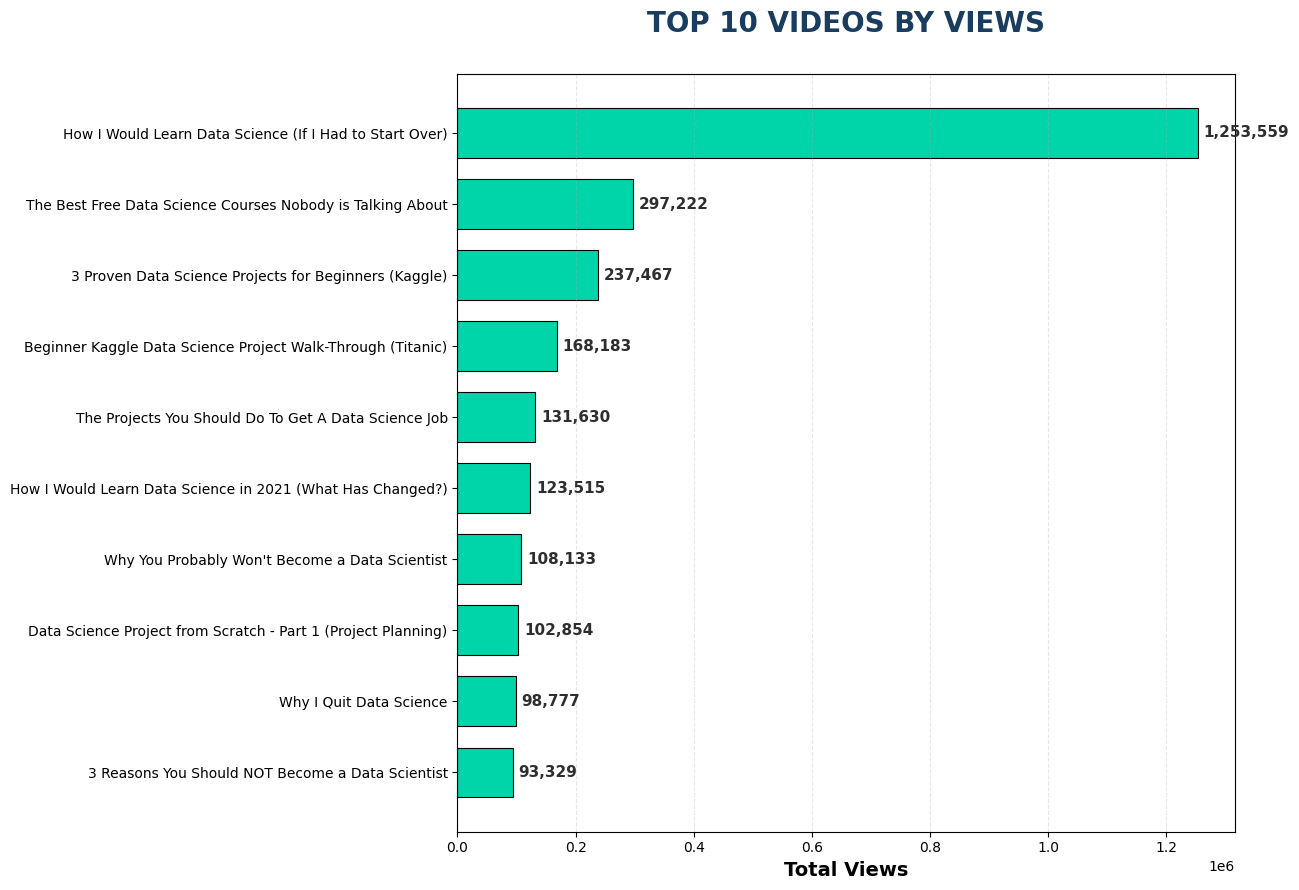


CHAMPION VIDEO OF ALL TIME:
   'How I Would Learn Data Science (If I Had to Start Over)'
   Views: 1,253,559
   Revenue: $7,959.53
   Watch Hours: 65,850.7h
   Revenue per View: $0.00635
   Likes: 46,903 | Comments: 907


In [ ]:
def run(sql):
    print("Running...")
    job = client.query(sql)
    job.result()
    rows = getattr(job, 'num_dml_affected_rows', 'N/A')
    print(f"Done → {rows} rows")

# 1. GOLD DASHBOARD
run(f"DROP TABLE IF EXISTS `{FULL_DATASET}.gold_creator_dashboard`;")

run(f"""
CREATE TABLE `{FULL_DATASET}.gold_creator_dashboard` AS
WITH cleaned AS (
  SELECT *
  FROM `{FULL_DATASET}.silver_video_enriched`
  WHERE video_title IS NOT NULL AND video_title != ''
)
SELECT
  video_surrogate_key,
  video_id,
  video_title,
  SUM(views)                          AS total_views,
  SUM(watch_time_minutes)              AS total_watch_minutes,
  ROUND(SUM(watch_time_minutes)/60, 1) AS total_watch_hours,
  AVG(avg_view_percentage)             AS avg_view_percentage,
  SUM(likes)                           AS total_likes,
  SUM(comments_added)                  AS total_comments,
  SUM(estimated_revenue_usd)           AS total_revenue_usd,
  ROUND(SUM(estimated_revenue_usd) / NULLIF(SUM(views), 0), 5) AS revenue_per_view
FROM cleaned
GROUP BY 1, 2, 3
ORDER BY total_views DESC;
""")

# 2. DQ LOG FUNCTION
def log_dq(name, failed):
    client.insert_rows_json(f"{FULL_DATASET}.dq_results", [{
        "run_ts": datetime.now(timezone.utc).isoformat(),
        "check_name": name,
        "status": "PASS" if failed == 0 else "FAIL",
        "failed_rows": int(failed),
        "message": ""
    }])
    print(f"   → {name}: {'PASS' if failed == 0 else 'FAIL'} ({failed})")

# DQ CHECKS
nulls = client.query(f"SELECT COUNT(*) FROM `{FULL_DATASET}.silver_video_enriched` WHERE video_title IS NULL").to_dataframe().iloc[0,0]
log_dq("no_null_titles_in_silver", nulls)

# 3. FINAL DASHBOARD
gold = client.query(f"SELECT * FROM `{FULL_DATASET}.gold_creator_dashboard`").to_dataframe()

print(f"\nGOLD LAYER 100% COMPLETE!")
print(f"{len(gold):,} videos in final dashboard\n")
display(gold.head(10))

# 4. TOP 10 CHART — NOW 100% SAFE!
plt.figure(figsize=(13, 9))
top10 = gold.head(10).copy()

# Ensure no None in titles
top10['video_title'] = top10['video_title'].fillna("Untitled Video")

# Plot
bars = plt.barh(
    top10['video_title'][::-1],
    top10['total_views'][::-1],
    color='#00D4A9',
    edgecolor='black',
    linewidth=0.8,
    height=0.7
)

plt.xlabel('Total Views', fontsize=14, fontweight='bold')
plt.title('TOP 10 VIDEOS BY VIEWS', fontsize=20, fontweight='bold', color='#1A3C5E', pad=30)
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Add numbers on bars
for i, (title, views) in enumerate(zip(top10['video_title'][::-1], top10['total_views'][::-1])):
    plt.text(views + 10000, i, f'{views:,}', va='center', fontsize=11, fontweight='bold', color='#2E2E2E')

plt.tight_layout()
plt.show()

# CHAMPION VIDEO
champ = gold.iloc[0]
print(f"\nCHAMPION VIDEO OF ALL TIME:")
print(f"   '{champ.video_title}'")
print(f"   Views: {champ.total_views:,}")
print(f"   Revenue: ${champ.total_revenue_usd:,.2f}")
print(f"   Watch Hours: {champ.total_watch_hours:,.1f}h")
print(f"   Revenue per View: ${champ.revenue_per_view:.5f}")
print(f"   Likes: {champ.total_likes:,} | Comments: {champ.total_comments:,}")